In [1]:
import pyomo.environ as pe
import pandas as pd
import numpy as np

### Data

In [2]:
np.random.seed(120)

In [3]:
plants = ['pl1', 'pl2']

In [4]:
customer = ['cus1']

In [5]:
demand = {}
for c in customer:
    d_aux = {}
    for i in pe.RangeSet(1,100):
        d_aux[i] = np.random.uniform(0,105)
    demand[c] = d_aux  

### Parameters

In [6]:
invCap = 1000        # inventory capacity
maxQ = 1000          # max order quantity
orderCost = 500      # cost for each order
holdCost = 2         # holding cost (per unit, per time period)
leadtime = 10        # lead time
backLogCost = 10     # backlogged orders penalty (per unit, per time period)
maxBackLogged = 1000 # big-M
initialInv = 500    # initial inventory
transp_cost = {'pl1': 2, 'pl2': 1}

### Model

In [7]:
m = pe.ConcreteModel()

In [8]:
# sets
m.time = pe.Set(initialize = pe.RangeSet(1,100))
m.cust = pe.Set(initialize = customer)
m.plants = pe.Set(initialize = plants)

In [9]:
# devision variables
m.Q  = pe.Var(bounds=[0,maxQ],domain = pe.NonNegativeReals)
m.R = pe.Var(bounds=[0,invCap],domain = pe.NonNegativeReals)
m.inv = pe.Var(m.time,bounds=[0,invCap],domain = pe.NonNegativeReals)
m.back = pe.Var(m.time,bounds = [0,maxBackLogged],domain = pe.NonNegativeReals)
m.low = pe.Var(m.time,domain = pe.Binary)
m.order = pe.Var(m.time,domain = pe.Binary)
m.repl = pe.Var(m.time,m.plants,domain = pe.NonNegativeReals)
m.delta = pe.Var(m.time,domain = pe.Binary)

In [10]:
# objective

def objective(model):
    return orderCost * sum(m.order[t] for t in m.time) + holdCost * sum(m.inv[t] for t in m.time) + backLogCost * sum(m.back[t] for t in m.time) \
        + sum(transp_cost[p] * m.repl[t,p] for t in m.time for p in m.plants)
m.objective = pe.Objective(rule = objective, sense = pe.minimize)

In [11]:
# constraints

# inventory balance
def inv_balance(model,t):
    if t == 1:
        return m.inv[t] - m.back[t] == sum(m.repl[t,p] for p in m.plants) + initialInv - sum(demand[c][t] for c in m.cust)
    else:
        return m.inv[t] - m.back[t] == m.inv[t-1] - m.back[t-1] - sum(demand[c][t] for c in m.cust) + sum(m.repl[t,p] for p in m.plants)
m.inv_balance = pe.Constraint(m.time,rule = inv_balance)

# inventory cap delta
def inv_cap_delta(model,t):
    return m.inv[t] <= invCap * m.delta[t]
m.inv_cap_delta = pe.Constraint(m.time,rule = inv_cap_delta)

# backlogged
def back_cap(model,t):
    return m.back[t] <= maxBackLogged * (1-m.delta[t])
m.back_cap = pe.Constraint(m.time,rule=back_cap)

# inventory low first constraint
def inv_low_1(model,t):
    return m.inv[t] <= m.R + invCap * (1 - m.low[t])
m.inv_low_1 = pe.Constraint(m.time,rule=inv_low_1)

# inventory low second constraint
def inv_low_2(model,t):
    return m.inv[t] >= m.R + 1 - (invCap + 1) * m.low[t]
m.inv_low_2 = pe.Constraint(m.time,rule = inv_low_2)

# inventory reorder first constraint
def reorder_1(model,t):
    if t > 1:
        return m.order[t] <= 1 - m.low[t-1]
    else:
        return m.order[t] <= 1
m.reorder_1 = pe.Constraint(m.time,rule = reorder_1)

# inventory reorder second constraint
def reorder_2(model,t):
    return m.order[t] <= m.low[t]
m.reorder_2 = pe.Constraint(m.time,rule = reorder_2)

# inventory reorder third constraint
def reorder_3(model,t):
    if t > 1:
        return m.order[t] >= m.low[t] - m.low[t-1]
    else:
        return m.order[t] >= m.low[t]
    
# inventory replenish first constraint   
def inv_replen(model,t):
    if t > leadtime:
        return sum(m.repl[t,p] for p in m.plants) <= maxQ * m.order[t-leadtime]
    else:
        return sum(m.repl[t,p] for p in m.plants) <= 0
m.inv_replen = pe.Constraint(m.time,rule = inv_replen)

# inventory replenish second constraint 
def inv_replen_2(model,t):
    return sum(m.repl[t,p] for p in m.plants) <= m.Q
m.inv_replen_2 = pe.Constraint(m.time,rule=inv_replen_2)

# inventory replenish third constraint 
def inv_replen_3(model,t):
    if t > leadtime:
        return sum(m.repl[t,p] for p in m.plants) >= m.Q - maxQ * (1 - m.order[t-leadtime])
    else:
        return sum(m.repl[t,p] for p in m.plants) >= m.Q - maxQ
m.inv_replen_3 = pe.Constraint(m.time,rule = inv_replen_3)

In [12]:
optimizer = pe.SolverFactory('cbc')

In [13]:
results = optimizer.solve(m,options = {"threads":4},tee = True)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - /home/victormoura/anaconda3/envs/iff_opt/bin/cbc -threads 4 -printingOptions all -import /tmp/tmpq7nddorm.pyomo.lp -stat=1 -solve -solu /tmp/tmpq7nddorm.pyomo.soln (default strategy 1)
threads was changed from 0 to 4
Option for printingOptions changed from normal to all
Presolve 959 (-42) rows, 582 (-121) columns and 2476 (-502) elements
Statistics for presolved model
Original problem has 300 integers (300 of which binary)
Presolved problem has 300 integers (300 of which binary)
==== 202 zero objective 6 different
202 variables have objective of 0
90 variables have objective of 1
90 variables have objective of 2
90 variables have objective of 10
10 variables have objective of 12
100 variables have objective of 500
==== absolute objective values 6 different
202 variables have objective of 0
90 variables have objective of 1
90 variables have objective of 2
90 variables have objective of 10
10 variab

In [14]:
inv = m.inv.extract_values()

In [15]:
col = ['time','inventory']
df = pd.DataFrame(columns=col)
for ivalues in inv.keys():
    df = pd.concat([df,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues,
                                col[1]:inv[ivalues]
                            }])],ignore_index=True)

In [16]:
supply = m.repl.extract_values()

In [19]:
col = ['time','plant','supply']
df_ = pd.DataFrame(columns=col)
for ivalues in supply.keys():
    df_ = pd.concat([df_,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues[0],
                                col[1]:ivalues[1],
                                col[2]:supply[ivalues]
                            }])],ignore_index=True)

In [21]:
col = ['time','demand']
df_demand = pd.DataFrame(columns=col)
for ivalues in demand['cus1'].keys():
    df_demand = pd.concat([df_demand,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues,
                                col[1]:demand['cus1'][ivalues]
                            }])],ignore_index=True)

In [22]:
import matplotlib.pyplot as plt

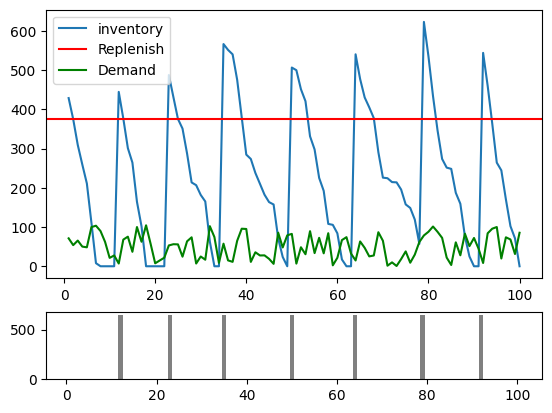

In [23]:
f, (a0,a1) = plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 1/4]})

a0.plot(df['time'],df['inventory'])
a0.axhline(y = m.R(),color = 'r')
a0.plot(df_demand['time'],df_demand['demand'], color = 'g')
a0.legend(['inventory','Replenish','Demand'])
a1.bar(df_['time'],df_['supply'],color ='#808080',width = 1)
plt.show()